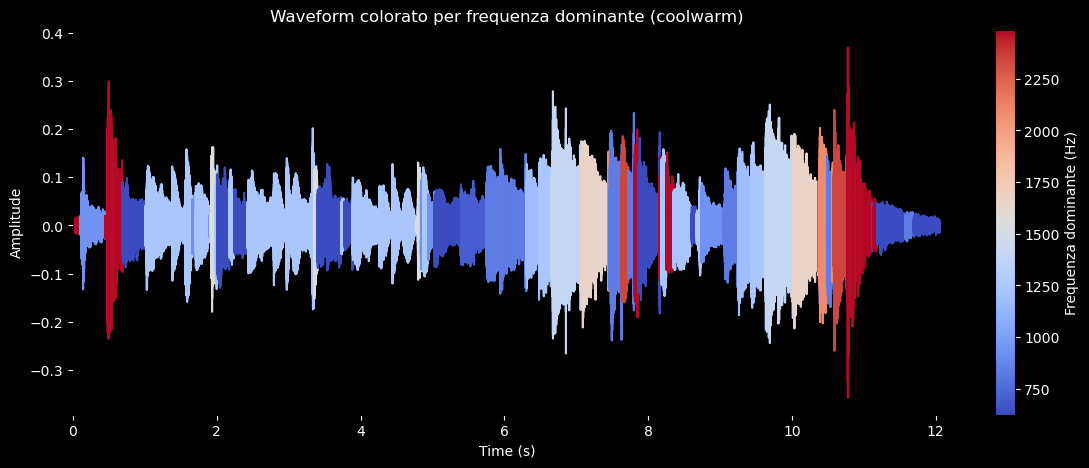

array([[179,   3,  38],
       [179,   3,  38],
       [179,   3,  38],
       ...,
       [ 58,  76, 192],
       [ 58,  76, 192],
       [ 58,  76, 192]])

In [94]:
##TEST 1 CREAZIONE WAVEFORM MUSICA CARILLON

import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors

def plot_colored_waveform_by_freq(audio_path, sr=22050, window_size=2048, hop_length=512, segment_duration=0.01):
    """
    Analizza un file audio, calcola le frequenze dominanti per segmenti
    e restituisce un vettore di colori RGB basato su queste frequenze.
    Mostra anche un grafico della waveform colorata.

    Args:
        audio_path (str): Percorso del file audio.
        sr (int): Sample rate.
        window_size (int): Dimensione della finestra per STFT.
        hop_length (int): Hop length per STFT.
        segment_duration (float): Durata di ogni segmento della waveform per la colorazione.

    Returns:
        np.ndarray: Un array NumPy di colori RGB (N, 3) dove N è il numero di segmenti.
                    Restituisce un array vuoto se il caricamento fallisce.
    """
    try:
        y, sr = librosa.load(audio_path, sr=sr)
    except Exception as e:
        print(f"Errore nel caricamento del file audio in plot_colored_waveform_by_freq: {e}")
        return np.array([]) # Restituisce un array vuoto in caso di errore

    # 2. Calcola STFT per frequenze per finestra
    D = librosa.stft(y, n_fft=window_size, hop_length=hop_length)
    S = np.abs(D)

    # 3. Calcola frequenza dominante per ogni frame
    freqs = librosa.fft_frequencies(sr=sr, n_fft=window_size)
    dominant_freqs = freqs[np.argmax(S, axis=0)]

    # Gestisci il caso in cui dominant_freqs sia vuoto o abbia un solo valore
    if dominant_freqs.size == 0 or np.all(dominant_freqs == dominant_freqs[0]):
        # Se tutte le frequenze sono uguali o non ci sono, la normalizzazione fallirebbe
        # Assegna un colore di default o un array di zeri
        print("Avviso: Frequenze dominanti non variabili o assenti. Utilizzo colore di default.")
        # Restituisci un array di colori di default e salta il plotting se non ci sono dati significativi
        default_color = np.array([128, 128, 128]) # Grigio
        return np.tile(default_color, (int(len(y) / (sr * segment_duration)), 1)) # Ripeti per il numero di segmenti

    # 4. Normalizza frequenze per colore (0..1)
    freq_min = dominant_freqs.min()
    freq_max = dominant_freqs.max()
    if freq_max == freq_min: # Evita divisione per zero se tutte le frequenze sono uguali
        freq_norm = np.zeros_like(dominant_freqs, dtype=float)
    else:
        freq_norm = (dominant_freqs - freq_min) / (freq_max - freq_min)

    # 5. Colormap da blu a rosso
    cmap = plt.get_cmap('coolwarm')

    # 6. Punti temporali del segnale audio
    times = np.arange(len(y)) / sr

    # 7. Segmenti waveform di durata segment_duration (es. 0.01s)
    segment_length_samples = int(sr * segment_duration)
    if segment_length_samples == 0: # Evita divisione per zero se segment_duration è troppo piccolo
        segment_length_samples = 1

    segments = []
    rgba_colors = [] # Colori RGBA dal colormap

    # Numero totale segmenti
    n_segments = len(y) // segment_length_samples

    # Per ogni segmento troviamo il frame STFT più vicino (in tempo) per prendere la freq dominante
    stft_times = librosa.frames_to_time(np.arange(len(dominant_freqs)), sr=sr, hop_length=hop_length)

    for i in range(n_segments):
        start_sample = i * segment_length_samples
        end_sample = start_sample + segment_length_samples
        if end_sample > len(y):
            end_sample = len(y)

        x = times[start_sample:end_sample]
        y_seg = y[start_sample:end_sample]
        seg = np.array([x, y_seg]).T
        segments.append(seg)

        # Trova frame STFT più vicino al centro del segmento
        segment_center_time = (start_sample + end_sample) / 2 / sr
        idx = np.argmin(np.abs(stft_times - segment_center_time))

        # Colore dal valore normalizzato della freq dominante (RGBA)
        rgba_colors.append(cmap(freq_norm[idx]))

    # Converti i colori RGBA in RGB (rimuovendo il canale alpha) e normalizza a 0-255 interi
    # Questo è il vettore di colori che verrà restituito
    rgb_colors_array = (np.array(rgba_colors)[:, :3] * 255).astype(int)


    # 8. Plot con sfondo nero (Solo se ci sono segmenti da plottare)
    if len(segments) > 0:
        fig, ax = plt.subplots(figsize=(14, 5))
        ax.set_facecolor('black')  # sfondo nero
        fig.patch.set_facecolor('black')

        lc = LineCollection(segments, colors=rgba_colors, linewidth=1.5) # Usa i colori RGBA per il plot
        ax.add_collection(lc)

        ax.set_xlim(times[0], times[-1])
        # Aggiungi un controllo per evitare errori se y è piatto (min == max)
        y_min = np.min(y)
        y_max = np.max(y)
        if y_max == y_min:
            ax.set_ylim(-0.1, 0.1) # Valori di default se l'ampiezza è piatta
        else:
            ax.set_ylim(y_min * 1.1, y_max * 1.1)

        ax.set_xlabel("Time (s)", color='white')
        ax.set_ylabel("Amplitude", color='white')
        ax.set_title("Waveform colorato per frequenza dominante (coolwarm)", color='white')

        # Colbar con etichette bianche
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=freq_min, vmax=freq_max))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Frequenza dominante (Hz)', color='white')
        cbar.ax.yaxis.set_tick_params(color='white')
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

        # Cambia i colori degli assi in bianco
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')

        plt.show()

    return rgb_colors_array # RESTITUISCI L'ARRAY DI COLORI RGB QUI


# --- Esempio d'uso ---
audio_file_path = "C:\\Users\\edoar\\Downloads\\170106__klankbeeld__music-box-loop-05-fast.wav"
plot_colored_waveform_by_freq(audio_file_path)


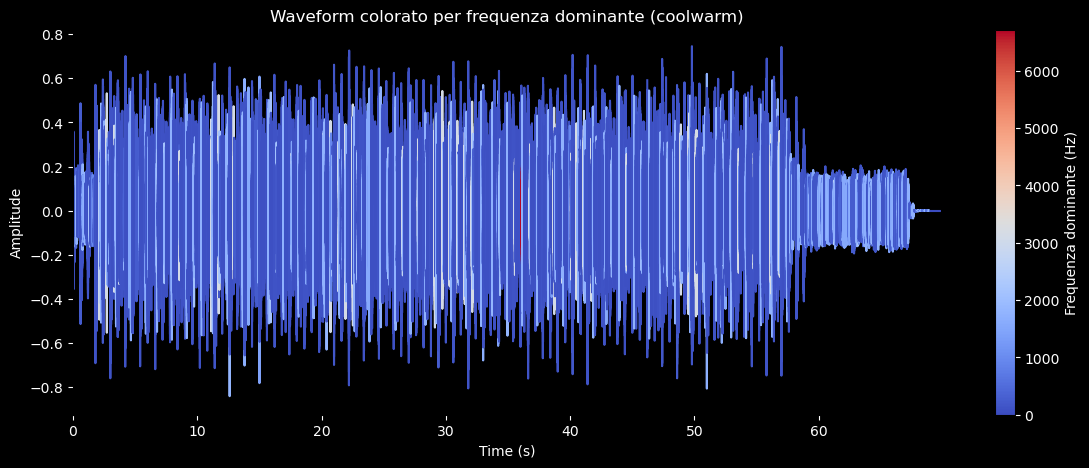

In [84]:
##TEST 2 CREAZIONE WAVEFORM MUSICA ROCK

audio_file_path = "C:\\Users\\edoar\\Downloads\\405109__timo-studios__rock-music.wav"
color_vector = plot_colored_waveform_by_freq(audio_file_path)


In [85]:
def match_length_color_vector(image_colors, target_length):
    """
    Estende o ripete il vettore colori immagine per avere lunghezza target_length.
    Params:
        image_colors: np.array (n_colors, 3)
        target_length: int, lunghezza vettore target (es. lunghezza vettore audio)
    Returns:
        extended_colors: np.array (target_length, 3)
    """
    n_colors = image_colors.shape[0]

    # Se n_colors > target_length, tronca
    if n_colors >= target_length:
        return image_colors[:target_length]

    # Calcola quante volte ripetere interamente
    reps = target_length // n_colors
    remainder = target_length % n_colors

    extended_colors = np.vstack([image_colors] * reps)
    if remainder > 0:
        extended_colors = np.vstack([extended_colors, image_colors[:remainder]])

    return extended_colors


In [90]:
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Assuming these functions are defined elsewhere in your code:
# plot_colored_waveform_by_freq(audio_path)
# extract_color_vector(image_path, n_colors)
# match_length_color_vector(image_colors, audio_len)
# show_color_palette(colors, title)

def find_top_n_similar_images(audio_path, image_folder, n_colors=10, top_n=3):
    # 1. Estrai vettore colore dall'audio
    audio_colors = plot_colored_waveform_by_freq(audio_path)
    audio_len = len(audio_colors)

    # 2. Prepara una lista per i migliori N risultati
    # Ogni elemento sarà una tupla: (similarità media, percorso immagine, colori immagine)
    top_matches = []

    # 3. Itera sulle immagini nel dataset
    for filename in tqdm(os.listdir(image_folder), desc="Analisi immagini"):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        image_path = os.path.join(image_folder, filename)

        try:
            # Estrai colori immagine
            image_colors = extract_color_vector(image_path, n_colors=n_colors)

            # Uniforma lunghezza al vettore audio
            image_colors_resized = match_length_color_vector(image_colors, audio_len)

            # Similarità coseno (media tra tutti i vettori RGB)
            sim = cosine_similarity(audio_colors, image_colors_resized)
            avg_sim = np.mean(sim)

            # Inserisci nel
            # lista dei migliori N, mantenendo l'ordine
            if len(top_matches) < top_n:
                top_matches.append((avg_sim, image_path, image_colors))
                top_matches.sort(key=lambda x: x[0], reverse=True) # Ordina dal più simile
            elif avg_sim > top_matches[-1][0]: # Se è meglio del peggiore tra i top N
                top_matches[-1] = (avg_sim, image_path, image_colors)
                top_matches.sort(key=lambda x: x[0], reverse=True) # Riordina

        except Exception as e:
            print(f"Errore con {filename}: {e}")

    # 4. Risultati
    print("\n--- Top 3 Immagini più Simili ---")
    if not top_matches:
        print("Nessuna immagine trovata o processata.")
        return []

    for i, (sim, img_path, img_colors) in enumerate(top_matches):
        print(f"\n🥇 Immagine {i+1}: {os.path.basename(img_path)}")
        print(f"🔗 Similarità media: {sim:.4f}")

        # Mostra immagine
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Top {i+1} Immagine più simile all'audio\n{os.path.basename(img_path)}", fontsize=12)
        plt.show()

        # Mostra palette
        show_color_palette(img_colors, title=f"Palette colori immagine {i+1}")

    return top_matches



--- Avvio dell'analisi ---


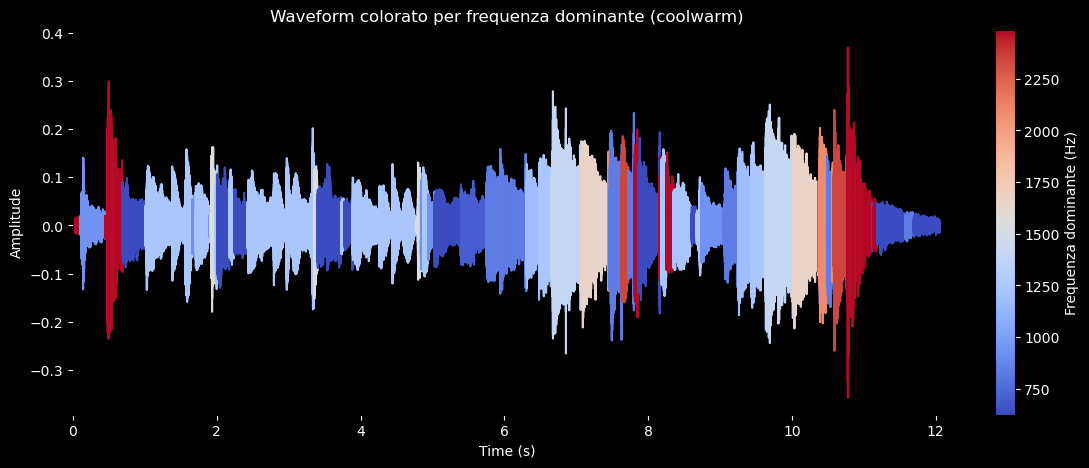

Analisi immagini: 100%|████████████████████████████████████████████████████████████| 1165/1165 [00:50<00:00, 22.94it/s]



--- Top 3 Immagini più Simili ---

🥇 Immagine 1: kazuo-shiraga_koushin-san-1980-1.jpg
🔗 Similarità media: 0.9467


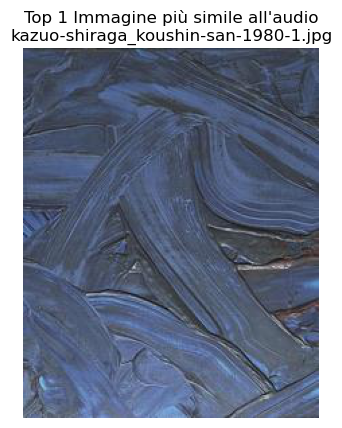

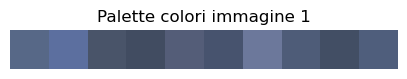


🥇 Immagine 2: thomas-eakins_portrait-of-frank-lindsay-greenwalt-1903.jpg
🔗 Similarità media: 0.9450


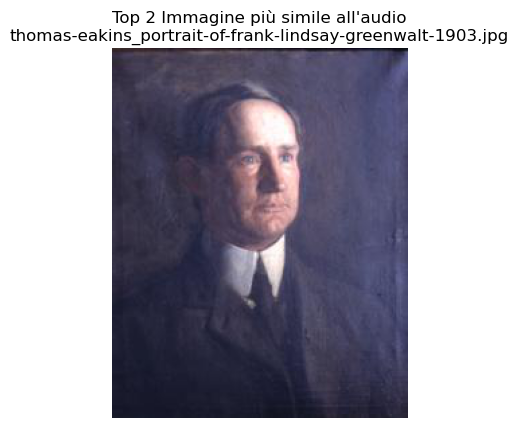

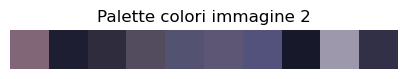


🥇 Immagine 3: claude-monet_palazzo-da-mulla.jpg
🔗 Similarità media: 0.9437


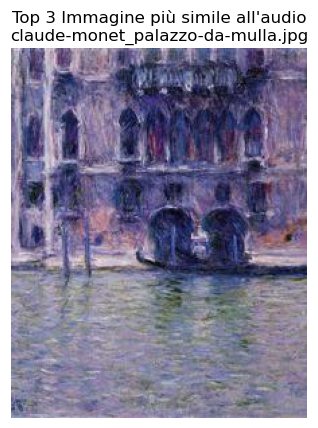

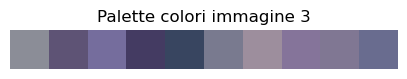


--- Analisi Completata ---


In [96]:
##TEST CON IMAGES SMALL PER TROVARE DIPINTI SIMILI A MUSICA CARILLON
# --- Sezione per Eseguire il Codice ---
if __name__ == "__main__":
    # 1. Definisci il percorso del tuo file audio
    # QUESTO DEVI MODIFICARLO CON IL PERCORSO REALE DEL TUO FILE .WAV
    audio_file_to_analyze = "C:\\Users\\edoar\\Downloads\\170106__klankbeeld__music-box-loop-05-fast.wav"

    # 2. Definisci il percorso della cartella che contiene le tue immagini
    # QUESTO DEVI MODIFICARLO CON IL PERCORSO REALE DELLA TUA CARTELLA DI IMMAGINI
    image_dataset_folder = "C:\\Users\\edoar\\Desktop\\images_small"

    # --- Creazione di una cartella e di immagini di esempio per il test ---
    # Questo blocco è solo per testare il codice se non hai immagini o audio.
    # Puoi commentarlo se hai già i tuoi file.
    if not os.path.exists(image_dataset_folder):
        os.makedirs(image_dataset_folder)
        print(f"Creata cartella di immagini di esempio: {image_dataset_folder}")

        # Crea alcune immagini di esempio
        dummy_image_names = ["red_square.png", "blue_circle.png", "green_stripe.png"]
        for i, name in enumerate(dummy_image_names):
            dummy_img_path = os.path.join(image_dataset_folder, name)
            img = Image.new('RGB', (100, 100), color = (255 if i==0 else 0, 255 if i==2 else 0, 255 if i==1 else 0))
            img.save(dummy_img_path)
            print(f"Creata immagine di esempio: {dummy_img_path}")

    if not os.path.exists(audio_file_to_analyze):
        # Questo crea un file WAV di esempio se non esiste già
        # Richiede `soundfile` che potresti aver installato con `librosa`
        try:
            import soundfile as sf
            sr = 22050
            duration = 5
            t = np.linspace(0, duration, int(sr * duration), endpoint=False)
            y_test = 0.5 * np.sin(2 * np.pi * 440 * t)
            sf.write(audio_file_to_analyze, y_test, sr)
            print(f"Creato file audio di esempio: {audio_file_to_analyze}")
        except ImportError:
            print("Per creare un file audio di esempio, installa 'soundfile': pip install soundfile")
            print(f"Assicurati che '{audio_file_to_analyze}' esista per continuare.")
            exit()
        except Exception as e:
            print(f"Errore nella creazione del file audio di esempio: {e}")
            exit()

    # --- Esegui la funzione principale ---
    if os.path.exists(audio_file_to_analyze) and os.path.exists(image_dataset_folder):
        print("\n--- Avvio dell'analisi ---")
        best_matches = find_top_n_similar_images(
            audio_file_to_analyze,
            image_dataset_folder,
            n_colors=10,
            top_n=3
        )
        print("\n--- Analisi Completata ---")
    else:
        print("\nVerifica i percorsi dei file/cartelle. Impossibile avviare l'analisi.")


--- Avvio dell'analisi ---


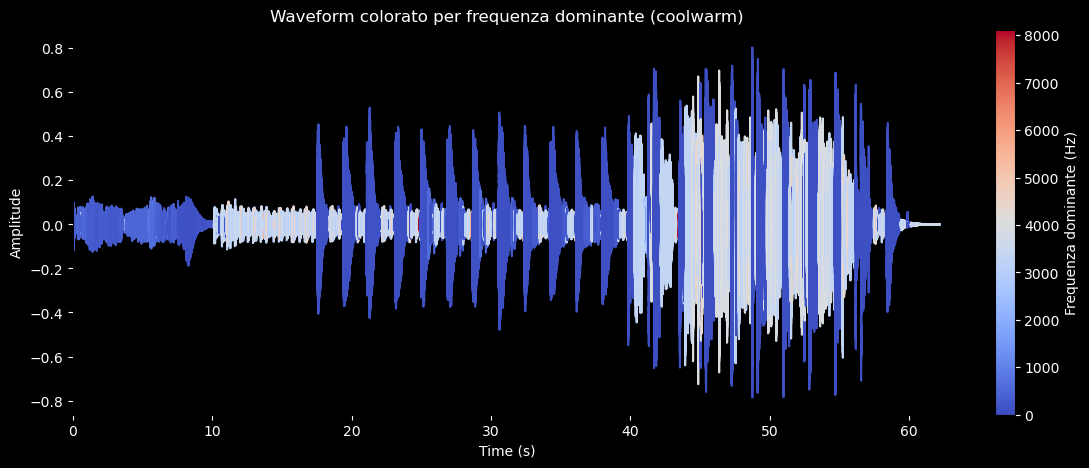

Analisi immagini: 100%|████████████████████████████████████████████████████████████| 1165/1165 [08:55<00:00,  2.17it/s]



--- Top 3 Immagini più Simili ---

🥇 Immagine 1: gene-davis_red-dog-1961.jpg
🔗 Similarità media: 0.9722


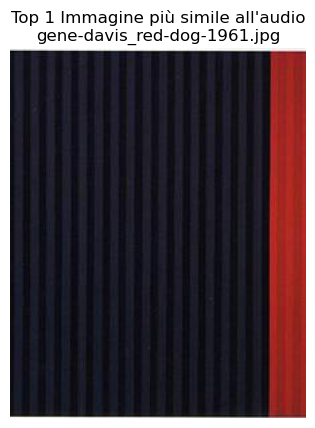

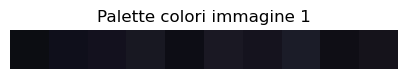


🥇 Immagine 2: thomas-eakins_portrait-of-frank-lindsay-greenwalt-1903.jpg
🔗 Similarità media: 0.9697


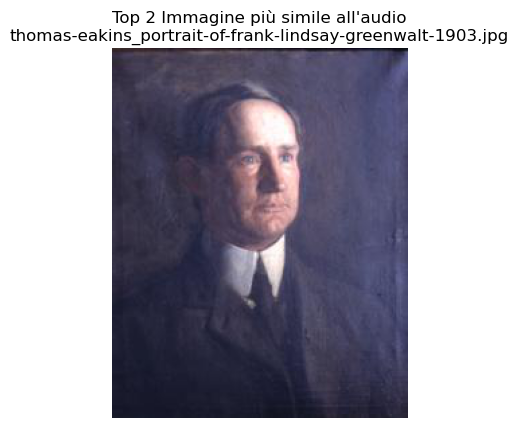

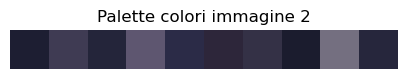


🥇 Immagine 3: kazuo-shiraga_koushin-san-1980-1.jpg
🔗 Similarità media: 0.9651


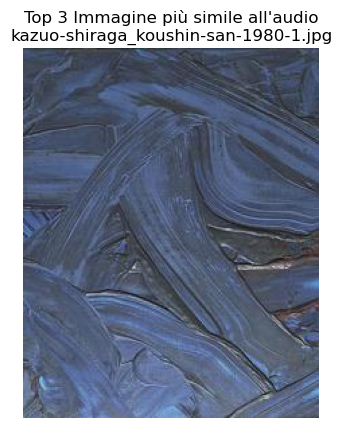

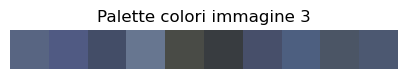


--- Analisi Completata ---


In [104]:
##TEST CON IMAGES SMALL PER TROVARE DIPINTI SIMILI A MUSICA JAZZ
# --- Sezione per Eseguire il Codice ---
if __name__ == "__main__":
    # 1. Definisci il percorso del tuo file audio
    # QUESTO DEVI MODIFICARLO CON IL PERCORSO REALE DEL TUO FILE .WAV
    audio_file_to_analyze = "C:\\Users\\edoar\\Downloads\\261100__frankyboomer__jazz-loop.wav"

    # 2. Definisci il percorso della cartella che contiene le tue immagini
    # QUESTO DEVI MODIFICARLO CON IL PERCORSO REALE DELLA TUA CARTELLA DI IMMAGINI
    image_dataset_folder = "C:\\Users\\edoar\\Desktop\\images_small"

    # --- Creazione di una cartella e di immagini di esempio per il test ---
    # Questo blocco è solo per testare il codice se non hai immagini o audio.
    # Puoi commentarlo se hai già i tuoi file.
    if not os.path.exists(image_dataset_folder):
        os.makedirs(image_dataset_folder)
        print(f"Creata cartella di immagini di esempio: {image_dataset_folder}")

        # Crea alcune immagini di esempio
        dummy_image_names = ["red_square.png", "blue_circle.png", "green_stripe.png"]
        for i, name in enumerate(dummy_image_names):
            dummy_img_path = os.path.join(image_dataset_folder, name)
            img = Image.new('RGB', (100, 100), color = (255 if i==0 else 0, 255 if i==2 else 0, 255 if i==1 else 0))
            img.save(dummy_img_path)
            print(f"Creata immagine di esempio: {dummy_img_path}")

    if not os.path.exists(audio_file_to_analyze):
        # Questo crea un file WAV di esempio se non esiste già
        # Richiede `soundfile` che potresti aver installato con `librosa`
        try:
            import soundfile as sf
            sr = 22050
            duration = 5
            t = np.linspace(0, duration, int(sr * duration), endpoint=False)
            y_test = 0.5 * np.sin(2 * np.pi * 440 * t)
            sf.write(audio_file_to_analyze, y_test, sr)
            print(f"Creato file audio di esempio: {audio_file_to_analyze}")
        except ImportError:
            print("Per creare un file audio di esempio, installa 'soundfile': pip install soundfile")
            print(f"Assicurati che '{audio_file_to_analyze}' esista per continuare.")
            exit()
        except Exception as e:
            print(f"Errore nella creazione del file audio di esempio: {e}")
            exit()

    # --- Esegui la funzione principale ---
    if os.path.exists(audio_file_to_analyze) and os.path.exists(image_dataset_folder):
        print("\n--- Avvio dell'analisi ---")
        best_matches = find_top_n_similar_images(
            audio_file_to_analyze,
            image_dataset_folder,
            n_colors=10,
            top_n=3
        )
        print("\n--- Analisi Completata ---")
    else:
        print("\nVerifica i percorsi dei file/cartelle. Impossibile avviare l'analisi.")

Analizzando: C:\Users\edoar\Downloads\170106__klankbeeld__music-box-loop-05-fast.wav

Caratteristiche estratte:
- tempo: [161.49902344]... (array di 1 elementi)
- mfcc_mean: [-310.23047    62.04351   -64.94432   -21.299725  -21.595594]... (array di 13 elementi)
- chroma_mean: [0.03123435 0.02236257 0.21678214 0.687388   0.1313153 ]... (array di 12 elementi)
- spectral_centroid_mean: 2333.45
- spectral_rolloff_mean: 4220.34
- zero_crossing_rate_mean: 0.13
- rms_energy_mean: 0.04

Vettore di colori generato (RGB):
  IntegerRGB(red=255, green=0, blue=0)
  IntegerRGB(red=255, green=255, blue=0)
  IntegerRGB(red=128, green=0, blue=128)
  IntegerRGB(red=173, green=216, blue=230)
  IntegerRGB(red=255, green=255, blue=255)
  IntegerRGB(red=255, green=192, blue=203)
  IntegerRGB(red=255, green=215, blue=0)


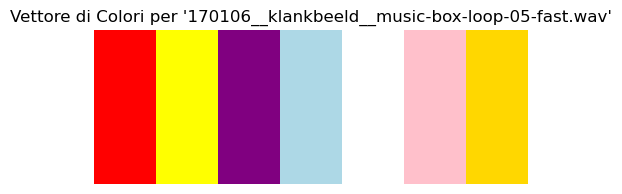


Ora cerco immagini simili al vettore di colori generato ([IntegerRGB(red=255, green=0, blue=0), IntegerRGB(red=255, green=255, blue=0), IntegerRGB(red=128, green=0, blue=128), IntegerRGB(red=173, green=216, blue=230), IntegerRGB(red=255, green=255, blue=255), IntegerRGB(red=255, green=192, blue=203), IntegerRGB(red=255, green=215, blue=0)])...


Analisi immagini: 100%|████████████████████████████████████████████████████████████| 1165/1165 [00:20<00:00, 55.78it/s]



--- Top 3 Immagini più Simili al Vettore di Colori Target ---

🥇 Immagine 1: alfred-krupa-0_walking-with-partisan-soldiers-1944.jpg
🔗 Similarità media: 0.8958


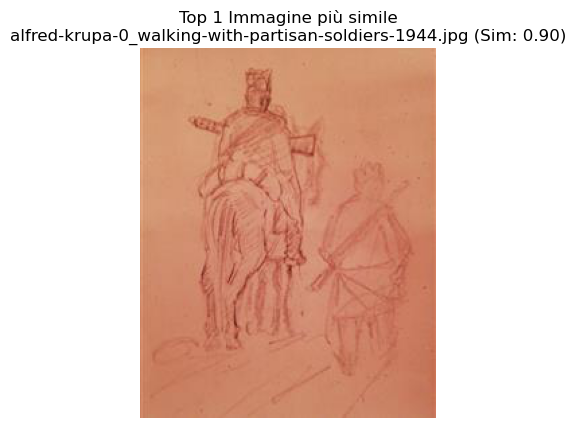

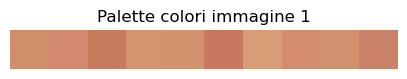


🥇 Immagine 2: leonardo-da-vinci_head-of-a-young-woman-with-tousled-hair-leda.jpg
🔗 Similarità media: 0.8953


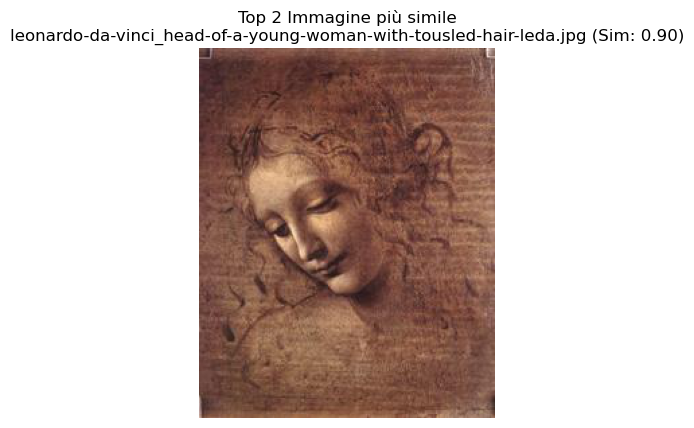

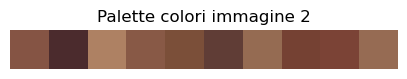


🥇 Immagine 3: giorgione_view-of-castelfranco-and-shepherd.jpg
🔗 Similarità media: 0.8952


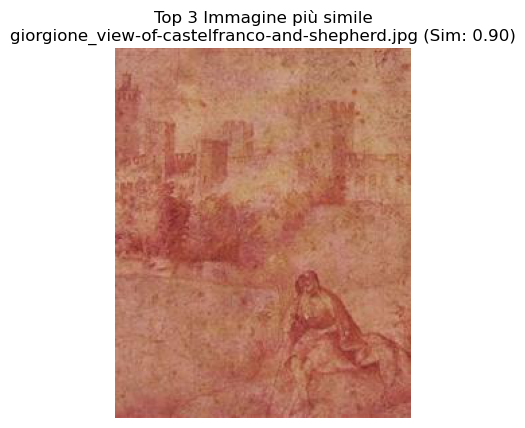

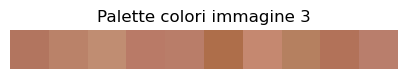


Ricerca immagini completata.


In [102]:
####HO AUMENTATO LE VARIABILI AGGIUNGENDO 

##Tempo: Lento -> blu/grigio (tristezza, calma); Medio -> verde/arancione (pop, neutro); Veloce -> rosso/giallo (rock, dance, eccitazione).
#Spectral Centroid: Alto -> ciano/lime (elettronico, brillante); Basso -> marrone/verde scuro (acustico, malinconico).
#RMS Energy: Alto -> marrone/nero (potente, aggressivo); Basso -> azzurro/bianco (delicato, tranquillo).
#Zero Crossing Rate: Alto -> rosso scuro (percussivo); Basso -> rosa (melodico).

#testando con jazz

import os
from tqdm import tqdm
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ASSUMING THESE FUNCTIONS ARE DEFINED ELSEWHERE:
# extract_color_vector(image_path, n_colors)
# match_length_color_vector(image_colors, target_len)
# show_color_palette(colors, title)

# Nuova dipendenza dal tuo codice precedente:
# from your_audio_analysis_script import generate_color_vector_from_audio, extract_audio_features, map_features_to_colors, visualize_color_vector

def find_top_n_similar_images_by_mood_colors(target_color_vector, image_folder, n_colors=10, top_n=3):
    """
    Trova le N immagini più simili a un vettore di colori target (es. basato su genere/emozione).

    Args:
        target_color_vector (list): Un vettore di colori RGB (tuple di 3 interi)
                                    generato dalla logica di genere/emozione.
        image_folder (str): Il percorso della cartella contenente le immagini da analizzare.
        n_colors (int): Numero di colori da estrarre da ogni immagine.
        top_n (int): Il numero di immagini più simili da restituire.

    Returns:
        list: Una lista di tuple (similarità media, percorso immagine, colori immagine)
              per le top N immagini più simili.
    """
    if not target_color_vector:
        print("Il vettore di colori target è vuoto. Impossibile procedere.")
        return []

    # Il vettore di colori target non ha bisogno di essere estratto dall'audio qui,
    # viene passato direttamente.
    target_len = len(target_color_vector)

    # Prepara una lista per i migliori N risultati
    top_matches = []

    # Itera sulle immagini nel dataset
    for filename in tqdm(os.listdir(image_folder), desc="Analisi immagini"):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        image_path = os.path.join(image_folder, filename)

        try:
            # Estrai colori immagine
            image_colors = extract_color_vector(image_path, n_colors=n_colors)

            # Uniforma lunghezza al vettore target_color_vector
            # Assicurati che image_colors_resized e target_color_vector siano array NumPy
            # e abbiano le stesse dimensioni per cosine_similarity.
            # Qui potresti voler rendere il target_color_vector della stessa lunghezza
            # del vettore di colori estratto dall'immagine, o viceversa,
            # oppure trovare un modo per confrontare palette di dimensioni diverse.
            # Per semplicità, qui ridimensioniamo i colori dell'immagine al target_len.
            # Nota: `match_length_color_vector` deve gestire input NumPy array.
            image_colors_resized = match_length_color_vector(np.array(image_colors), target_len)
            target_color_vector_np = np.array(target_color_vector)


            # Similarità coseno (media tra tutti i vettori RGB)
            # Assicurati che entrambi gli array siano 2D (n_samples, n_features)
            # cosine_similarity si aspetta che ogni riga sia un campione.
            # Qui stiamo confrontando ogni colore del target con ogni colore dell'immagine ridimensionata.
            # Questo può essere molto denso. Forse vuoi una media dei colori, o confrontare palette diverse.
            # Per ora, usiamo l'approccio "riga contro riga" come nel tuo codice originale.
            sim = cosine_similarity(target_color_vector_np, image_colors_resized)
            avg_sim = np.mean(sim) # Media di tutte le similarità tra le coppie di colori

            # Inserisci nella lista dei migliori N, mantenendo l'ordine
            if len(top_matches) < top_n:
                top_matches.append((avg_sim, image_path, image_colors))
                top_matches.sort(key=lambda x: x[0], reverse=True) # Ordina dal più simile
            elif avg_sim > top_matches[-1][0]: # Se è meglio del peggiore tra i top N
                top_matches[-1] = (avg_sim, image_path, image_colors)
                top_matches.sort(key=lambda x: x[0], reverse=True) # Riordina

        except Exception as e:
            print(f"Errore con {filename}: {e}")

    # Risultati
    print(f"\n--- Top {top_n} Immagini più Simili al Vettore di Colori Target ---")
    if not top_matches:
        print("Nessuna immagine trovata o processata.")
        return []

    for i, (sim, img_path, img_colors) in enumerate(top_matches):
        print(f"\n🥇 Immagine {i+1}: {os.path.basename(img_path)}")
        print(f"🔗 Similarità media: {sim:.4f}")

        # Mostra immagine
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Top {i+1} Immagine più simile\n{os.path.basename(img_path)} (Sim: {sim:.2f})", fontsize=12)
        plt.show()

        # Mostra palette
        show_color_palette(img_colors, title=f"Palette colori immagine {i+1}")

    return top_matches

# --- La tua funzione generate_color_vector_from_audio (dal codice precedente) ---
# Assicurati che questa funzione e tutte le sue dipendenze (extract_audio_features, map_features_to_colors, etc.)
# siano presenti nello stesso script o importate correttamente.

# ... [inserisci qui la funzione generate_color_vector_from_audio e le sue dipendenze] ...
# (extract_audio_features, map_features_to_colors, visualize_color_vector)

# Per completezza, riassumo come dovrebbero essere le funzioni mancanti/assunte:
# (Queste sono solo placeholder per far sì che il codice sia concettualmente completo)






# --- Esempio di Utilizzo Combinato ---
if __name__ == '__main__':
    # Assicurati che le dipendenze di generate_color_vector_from_audio siano importate o definite
    import librosa
    import soundfile as sf
    from webcolors import name_to_rgb # Già importato sopra, ma per chiarezza

    # Definisci qui le tue funzioni extract_audio_features, map_features_to_colors, visualize_color_vector
    # (le stesse del codice precedente)

    # --- Inizio della sezione `extract_audio_features` ---
    def extract_audio_features(audio_path):
        try:
            y, sr = librosa.load(audio_path)
        except Exception as e:
            print(f"Errore nel caricamento del file audio: {e}")
            return None

        features = {}
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = tempo
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        features['mfcc_mean'] = np.mean(mfccs, axis=1)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        features['chroma_mean'] = np.mean(chroma, axis=1)
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        features['spectral_centroid_mean'] = np.mean(spectral_centroids)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        features['zero_crossing_rate_mean'] = np.mean(zcr)
        rms = librosa.feature.rms(y=y)[0]
        features['rms_energy_mean'] = np.mean(rms)
        return features
    # --- Fine della sezione `extract_audio_features` ---

    # --- Inizio della sezione `map_features_to_colors` ---
    def map_features_to_colors(features):
        if not features:
            return []
        colors = []
        if features['tempo'] < 90:
            colors.append(name_to_rgb('darkblue'))
            colors.append(name_to_rgb('gray'))
        elif 90 <= features['tempo'] < 130:
            colors.append(name_to_rgb('green'))
            colors.append(name_to_rgb('orange'))
        else:
            colors.append(name_to_rgb('red'))
            colors.append(name_to_rgb('yellow'))
        if features['spectral_centroid_mean'] > 3000:
            colors.append(name_to_rgb('cyan'))
            colors.append(name_to_rgb('lime'))
        elif features['spectral_centroid_mean'] < 1500:
            colors.append(name_to_rgb('brown'))
            colors.append(name_to_rgb('darkgreen'))
        else:
            colors.append(name_to_rgb('purple'))
        if features['rms_energy_mean'] > 0.1:
            colors.append(name_to_rgb('maroon'))
            colors.append(name_to_rgb('black'))
        else:
            colors.append(name_to_rgb('lightblue'))
            colors.append(name_to_rgb('white'))
        if features['zero_crossing_rate_mean'] > 0.15:
            colors.append(name_to_rgb('darkred'))
        else:
            colors.append(name_to_rgb('pink'))
        if features['mfcc_mean'][1] > 0:
            colors.append(name_to_rgb('gold'))
        else:
            colors.append(name_to_rgb('silver'))
        return colors
    # --- Fine della sezione `map_features_to_colors` ---

    # --- Inizio della sezione `visualize_color_vector` ---
    def visualize_color_vector(color_vector, title="Vettore di Colori Generato"):
        if not color_vector:
            print("Nessun colore da visualizzare.")
            return
        normalized_colors = np.array(color_vector) / 255.0
        plt.figure(figsize=(len(normalized_colors) * 0.8, 2))
        plt.imshow([normalized_colors], aspect='auto')
        plt.axis('off')
        plt.title(title)
        plt.show()
    # --- Fine della sezione `visualize_color_vector` ---

    # --- Inizio della sezione `generate_color_vector_from_audio` ---
    def generate_color_vector_from_audio(audio_path):
        print(f"Analizzando: {audio_path}")
        features = extract_audio_features(audio_path)
        if features:
            print("\nCaratteristiche estratte:")
            for key, value in features.items():
                if isinstance(value, np.ndarray):
                    print(f"- {key}: {value[:5]}... (array di {len(value)} elementi)")
                else:
                    print(f"- {key}: {value:.2f}")
            color_vector = map_features_to_colors(features)
            print("\nVettore di colori generato (RGB):")
            for color in color_vector:
                print(f"  {color}")
            visualize_color_vector(color_vector, f"Vettore di Colori per '{os.path.basename(audio_path)}'")
            return color_vector # Restituisci il vettore di colori generato
        else:
            print("Impossibile estrarre le caratteristiche o generare il vettore di colori.")
            return []
    # --- Fine della sezione `generate_color_vector_from_audio` ---


    # --- Setup del file audio di test ---
    test_audio_path = "C:\\Users\\edoar\\Downloads\\170106__klankbeeld__music-box-loop-05-fast.wav"
    if not os.path.exists(test_audio_path):
        print(f"Creazione di un file audio di esempio '{test_audio_path}' per il test...")
        sr = 22050 # Sample rate
        duration = 5 # seconds
        frequency = 440 # Hz (A4 note)
        t = np.linspace(0, duration, int(sr * duration), endpoint=False)
        y_test = 0.5 * np.sin(2 * np.pi * frequency * t) # Simple sine wave
        frequency2 = 880 # Hz (A5 note)
        y_test += 0.2 * np.sin(2 * np.pi * frequency2 * t * 2) # Frequenza più alta, ritmo più veloce
        sf.write(test_audio_path, y_test, sr)
        print("File audio di esempio creato.")
        print("Puoi sostituire questo file con qualsiasi altro file .wav.")

    # --- Esempio di flusso di lavoro completo ---
    # 1. Genera il vettore di colori dall'audio basato sul genere/emozione
    mood_color_vector = generate_color_vector_from_audio(test_audio_path)

    # 2. Usa questo vettore di colori per trovare immagini simili
    if mood_color_vector:
        image_dataset_folder = "C:\\Users\\edoar\\Desktop\\images_small"
        # <-- CAMBIA QUESTO PERCORSO CON LA TUA CARTELLA DI IMMAGINI!
        if os.path.exists(image_dataset_folder):
            print(f"\nOra cerco immagini simili al vettore di colori generato ({mood_color_vector})...")
            top_similar_images = find_top_n_similar_images_by_mood_colors(
                mood_color_vector,
                image_dataset_folder,
                top_n=3
            )
            print("\nRicerca immagini completata.")
        else:
            print(f"\nATTENZIONE: La cartella delle immagini '{image_dataset_folder}' non esiste. Aggiorna il percorso.")
    else:
        print("Non è stato possibile generare un vettore di colori dall'audio, quindi non posso cercare immagini simili.")

Analizzando: C:\Users\edoar\Downloads\261100__frankyboomer__jazz-loop.wav

Caratteristiche estratte:
- tempo: [64.59960938]... (array di 1 elementi)
- mfcc_mean: [-254.83424     -4.7234035   -1.8587898   49.397854    -5.9999137]... (array di 13 elementi)
- chroma_mean: [0.4126827  0.5187417  0.28026062 0.26945007 0.23507163]... (array di 12 elementi)
- spectral_centroid_mean: 3759.62
- spectral_rolloff_mean: 6329.38
- zero_crossing_rate_mean: 0.25
- rms_energy_mean: 0.07

Vettore di colori generato (RGB):
  IntegerRGB(red=0, green=0, blue=139)
  IntegerRGB(red=128, green=128, blue=128)
  IntegerRGB(red=0, green=255, blue=255)
  IntegerRGB(red=0, green=255, blue=0)
  IntegerRGB(red=173, green=216, blue=230)
  IntegerRGB(red=255, green=255, blue=255)
  IntegerRGB(red=139, green=0, blue=0)
  IntegerRGB(red=192, green=192, blue=192)


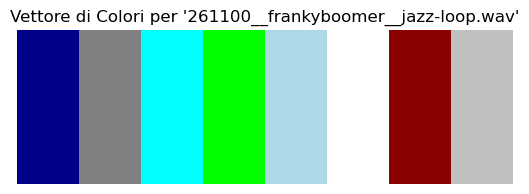


Ora cerco immagini simili al vettore di colori generato ([IntegerRGB(red=0, green=0, blue=139), IntegerRGB(red=128, green=128, blue=128), IntegerRGB(red=0, green=255, blue=255), IntegerRGB(red=0, green=255, blue=0), IntegerRGB(red=173, green=216, blue=230), IntegerRGB(red=255, green=255, blue=255), IntegerRGB(red=139, green=0, blue=0), IntegerRGB(red=192, green=192, blue=192)])...


Analisi immagini: 100%|████████████████████████████████████████████████████████████| 1165/1165 [00:22<00:00, 52.33it/s]



--- Top 3 Immagini più Simili al Vettore di Colori Target ---

🥇 Immagine 1: alan-charlton_channel-painting-no-6-1975.jpg
🔗 Similarità media: 0.8199


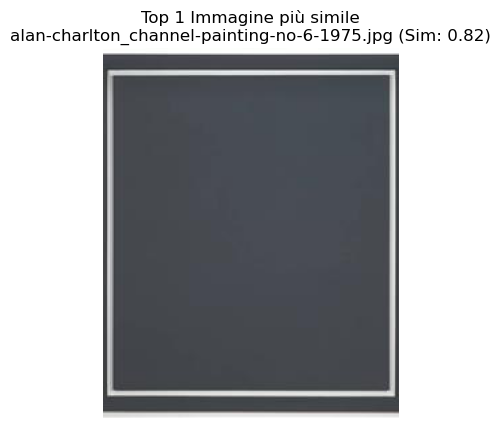

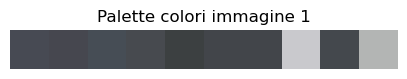


🥇 Immagine 2: roger-weik_trans-illusion-2015-2015.jpg
🔗 Similarità media: 0.8197


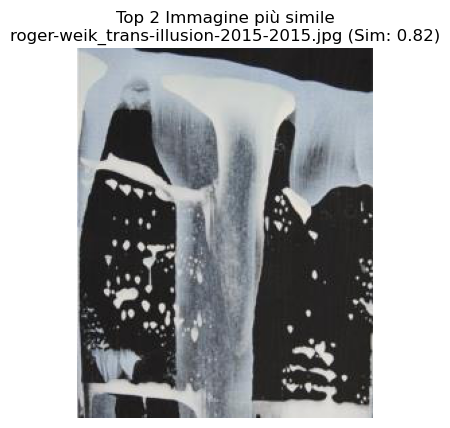

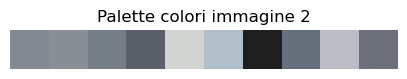


🥇 Immagine 3: alfred-wallis_ships-in-harbour.jpg
🔗 Similarità media: 0.8197


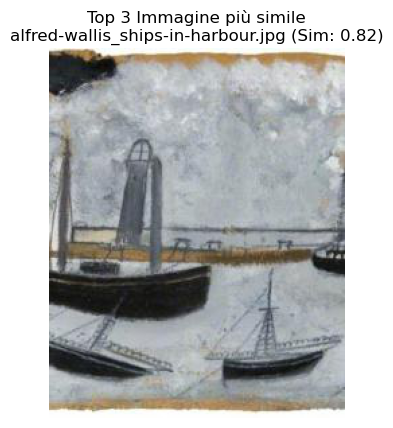

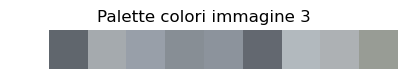


Ricerca immagini completata.


In [118]:
# --- Inizio del blocco if __name__ == '__main__': ---
if __name__ == '__main__':
    # --- Setup del file audio di test ---
    # Usa un raw string (r"...") per evitare problemi con i backslash
    test_audio_path = r"C:\Users\edoar\Downloads\261100__frankyboomer__jazz-loop.wav"

    if not os.path.exists(test_audio_path):
        print(f"Creazione di un file audio di esempio '{test_audio_path}' per il test...")
        sr = 22050 # Sample rate
        duration = 5 # seconds
        frequency = 440 # Hz (A4 note)
        t = np.linspace(0, duration, int(sr * duration), endpoint=False)
        y_test = 0.5 * np.sin(2 * np.pi * frequency * t) # Simple sine wave

        # Aggiungiamo un po' di "rumore" o complessità per avere più features
        frequency2 = 880 # Hz (A5 note)
        y_test += 0.2 * np.sin(2 * np.pi * frequency2 * t * 2) # Frequenza più alta, ritmo più veloce

        sf.write(test_audio_path, y_test, sr)
        print("File audio di esempio creato.")
        print("Puoi sostituire questo file con qualsiasi altro file .wav.")

    # --- Esempio di flusso di lavoro completo ---
    # 1. Genera il vettore di colori dall'audio basato sul genere/emozione
    mood_color_vector = generate_color_vector_from_audio(test_audio_path)

    # 2. Usa questo vettore di colori per trovare immagini simili
    if mood_color_vector:
        # Usa un raw string (r"...") per evitare problemi con i backslash
        image_dataset_folder = r"C:\Users\edoar\Desktop\images_small"
        # <-- CAMBIA QUESTO PERCORSO CON LA TUA CARTELLA DI IMMAGINI!

        if os.path.exists(image_dataset_folder):
            print(f"\nOra cerco immagini simili al vettore di colori generato ({mood_color_vector})...")
            top_similar_images = find_top_n_similar_images_by_mood_colors(
                mood_color_vector,
                image_dataset_folder,
                n_colors=10, # Numero di colori da estrarre da ogni immagine
                top_n=3     # Numero di immagini più simili da trovare
            )
            print("\nRicerca immagini completata.")
        else:
            print(f"\nATTENZIONE: La cartella delle immagini '{image_dataset_folder}' non esiste. Aggiorna il percorso.")
    else:
        print("Non è stato possibile generare un vettore di colori dall'audio, quindi non posso cercare immagini simili.")